In [1]:
import os
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
import csv

## Download Data

In [9]:
def read_dataset():
    df = pd.read_csv('https://media.githubusercontent.com/media/Benz-Poobua/ESS-469-Project/main/bulk_event_magnitude_phase_nwf_FV.csv', parse_dates=['datetime', 'arrdatetime'], index_col=[0])
    df.index = df.arid
    # Explicitly (re)define the bounding box used for the PNSN catalog query
    latll, lonll = 42.0, -125.5
    latur, lonur = 49.0, -122.0
    t0, t1 = UTCDateTime(2015,1,1), UTCDateTime(2023,11,17)
    df= df[
        (df.lat >= latll)
        & (df.lat <= latur)
        & (df.lon >= lonll)
        & (df.lon <= lonur)
    ]
    feature_df = df.copy().iloc[:, -140:]
    data_arr = np.empty((0, 140), dtype=np.float16)
    target_arr = np.empty((0, 1), dtype=np.float16)
    # dataframe of the last 140 columns to numpy array
    for i in df.arid.unique():
        data_arr = np.append(data_arr, np.array([feature_df.loc[i]], dtype=np.float16), axis=0)
        target_arr = np.append(target_arr, np.array([[df.loc[i].magnitude]], dtype=np.float16), axis=0)
    return data_arr, target_arr

In [10]:
def save_array(filename, arr):
    # save the array to a file
    np.save(filename, arr)

In [11]:
def import_array(filename):
    # import the array from the file
    arr = np.load(filename)
    return arr

In [12]:
# check if the file exists
if os.path.isfile('bulk_event_magnitude_phase_nwf_FV.npy') and os.path.isfile('bulk_event_magnitude_phase_nwf_FV_target.npy'):
    data_arr = import_array('bulk_event_magnitude_phase_nwf_FV.npy')
    target_arr = import_array('bulk_event_magnitude_phase_nwf_FV_target.npy')
else:
    data_arr, target_arr = read_dataset()
    save_array('bulk_event_magnitude_phase_nwf_FV.npy', data_arr)
    save_array('bulk_event_magnitude_phase_nwf_FV_target.npy', target_arr)

/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/pandas/core/series.py:893: RuntimeWarning: overflow encountered in cast
  return np.asarray(self._values, dtype)


In [13]:
X = data_arr # feature vectors
y = target_arr # magnitude

In [14]:
print(X.shape)
print(y.shape)

(65821, 140)
(65821, 1)


## Data Splitting

In [16]:
# Splitting the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(52656, 140)
(13165, 140)
(52656, 1)
(13165, 1)


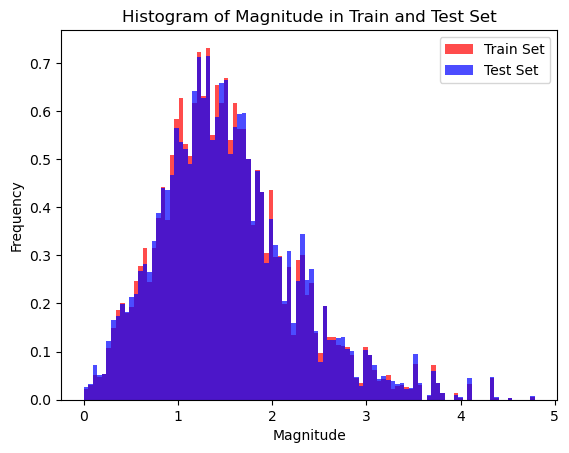

In [18]:
plt.hist(y_train, bins=100, density=True, alpha=0.7, color='red', label='Train Set')
plt.hist(y_test, bins=100, density=True, alpha=0.7, color='blue', label='Test Set')
#plt.hist(y, bins=100, density=True, alpha=0.3, color='yellow', label='Full Set')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Magnitude in Train and Test Set')
plt.show()

## K-fold Cross Validation 

In [19]:
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor

In [21]:
# K-fold cross-validation setting
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=False)

In [22]:
# XGBoost model wit MAE loss function
model = XGBRegressor(objective='reg:squarederror')

In [24]:
# X_train contains the features (f000, f001, ..., f139) and y_train contains 'magnitude'
# Perform cross-validation with MAE as the loss function
mae_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=kfold)

# Take the absolute values of the mean absolute error scores
mae_scores = -mae_scores

# Print the mean and standard deviation of MAE scores
print(f'Mean MAE: {mae_scores.mean()}')
print(f'Standard Deviation of MAE: {mae_scores.std()}')

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 1051, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 534, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 954, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1528, in __init__
    self._init(
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1589, in _init
    _check_call(ret)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:23:53] /Users/runner/work/xgboost/xgboost/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000145804355 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x0000000145923c29 void xgboost::GHistIndexMatrix::SetIndexData<xgboost::data::ArrayAdapterBatch, unsigned int, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&), xgboost::data::IsValidFunctor&>(xgboost::common::Span<xgboost::data::IsValidFunctor&, 18446744073709551615ul>, unsigned long, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, unsigned long, xgboost::data::ArrayAdapterBatch const&, xgboost::data::IsValidFunctor&, unsigned long, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&)&&) + 393
  [bt] (2) 3   libxgboost.dylib                    0x0000000145922817 void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>) + 455
  [bt] (3) 4   libxgboost.dylib                    0x00000001459221cd void xgboost::GHistIndexMatrix::PushAdapterBatch<xgboost::data::ArrayAdapterBatch>(xgboost::Context const*, unsigned long, unsigned long, xgboost::data::ArrayAdapterBatch const&, float, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, double, unsigned long) + 317
  [bt] (4) 5   libxgboost.dylib                    0x0000000145917656 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 10246
  [bt] (5) 6   libxgboost.dylib                    0x000000014591474c xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1356
  [bt] (6) 7   libxgboost.dylib                    0x00000001458c8f89 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 121
  [bt] (7) 8   libxgboost.dylib                    0x000000014580f44e XGQuantileDMatrixCreateFromCallback + 590
  [bt] (8) 9   libffi.8.dylib                      0x000000010a0e4972 ffi_call_unix64 + 82



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 1051, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 534, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 954, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1528, in __init__
    self._init(
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1589, in _init
    _check_call(ret)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:23:54] /Users/runner/work/xgboost/xgboost/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000145804355 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x0000000145923c29 void xgboost::GHistIndexMatrix::SetIndexData<xgboost::data::ArrayAdapterBatch, unsigned int, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&), xgboost::data::IsValidFunctor&>(xgboost::common::Span<xgboost::data::IsValidFunctor&, 18446744073709551615ul>, unsigned long, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, unsigned long, xgboost::data::ArrayAdapterBatch const&, xgboost::data::IsValidFunctor&, unsigned long, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&)&&) + 393
  [bt] (2) 3   libxgboost.dylib                    0x0000000145922817 void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>) + 455
  [bt] (3) 4   libxgboost.dylib                    0x00000001459221cd void xgboost::GHistIndexMatrix::PushAdapterBatch<xgboost::data::ArrayAdapterBatch>(xgboost::Context const*, unsigned long, unsigned long, xgboost::data::ArrayAdapterBatch const&, float, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, double, unsigned long) + 317
  [bt] (4) 5   libxgboost.dylib                    0x0000000145917656 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 10246
  [bt] (5) 6   libxgboost.dylib                    0x000000014591474c xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1356
  [bt] (6) 7   libxgboost.dylib                    0x00000001458c8f89 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 121
  [bt] (7) 8   libxgboost.dylib                    0x000000014580f44e XGQuantileDMatrixCreateFromCallback + 590
  [bt] (8) 9   libffi.8.dylib                      0x000000010a0e4972 ffi_call_unix64 + 82



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 1051, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 534, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 954, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1528, in __init__
    self._init(
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1589, in _init
    _check_call(ret)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:23:55] /Users/runner/work/xgboost/xgboost/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000145804355 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x0000000145923c29 void xgboost::GHistIndexMatrix::SetIndexData<xgboost::data::ArrayAdapterBatch, unsigned int, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&), xgboost::data::IsValidFunctor&>(xgboost::common::Span<xgboost::data::IsValidFunctor&, 18446744073709551615ul>, unsigned long, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, unsigned long, xgboost::data::ArrayAdapterBatch const&, xgboost::data::IsValidFunctor&, unsigned long, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&)&&) + 393
  [bt] (2) 3   libxgboost.dylib                    0x0000000145922817 void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>) + 455
  [bt] (3) 4   libxgboost.dylib                    0x00000001459221cd void xgboost::GHistIndexMatrix::PushAdapterBatch<xgboost::data::ArrayAdapterBatch>(xgboost::Context const*, unsigned long, unsigned long, xgboost::data::ArrayAdapterBatch const&, float, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, double, unsigned long) + 317
  [bt] (4) 5   libxgboost.dylib                    0x0000000145917656 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 10246
  [bt] (5) 6   libxgboost.dylib                    0x000000014591474c xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1356
  [bt] (6) 7   libxgboost.dylib                    0x00000001458c8f89 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 121
  [bt] (7) 8   libxgboost.dylib                    0x000000014580f44e XGQuantileDMatrixCreateFromCallback + 590
  [bt] (8) 9   libffi.8.dylib                      0x000000010a0e4972 ffi_call_unix64 + 82



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 1051, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 534, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 954, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1528, in __init__
    self._init(
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1589, in _init
    _check_call(ret)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:23:56] /Users/runner/work/xgboost/xgboost/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000145804355 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x0000000145923c29 void xgboost::GHistIndexMatrix::SetIndexData<xgboost::data::ArrayAdapterBatch, unsigned int, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&), xgboost::data::IsValidFunctor&>(xgboost::common::Span<xgboost::data::IsValidFunctor&, 18446744073709551615ul>, unsigned long, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, unsigned long, xgboost::data::ArrayAdapterBatch const&, xgboost::data::IsValidFunctor&, unsigned long, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&)&&) + 393
  [bt] (2) 3   libxgboost.dylib                    0x0000000145922817 void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>) + 455
  [bt] (3) 4   libxgboost.dylib                    0x00000001459221cd void xgboost::GHistIndexMatrix::PushAdapterBatch<xgboost::data::ArrayAdapterBatch>(xgboost::Context const*, unsigned long, unsigned long, xgboost::data::ArrayAdapterBatch const&, float, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, double, unsigned long) + 317
  [bt] (4) 5   libxgboost.dylib                    0x0000000145917656 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 10246
  [bt] (5) 6   libxgboost.dylib                    0x000000014591474c xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1356
  [bt] (6) 7   libxgboost.dylib                    0x00000001458c8f89 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 121
  [bt] (7) 8   libxgboost.dylib                    0x000000014580f44e XGQuantileDMatrixCreateFromCallback + 590
  [bt] (8) 9   libffi.8.dylib                      0x000000010a0e4972 ffi_call_unix64 + 82



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 1051, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 534, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 954, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1528, in __init__
    self._init(
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1589, in _init
    _check_call(ret)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:23:57] /Users/runner/work/xgboost/xgboost/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000145804355 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x0000000145923c29 void xgboost::GHistIndexMatrix::SetIndexData<xgboost::data::ArrayAdapterBatch, unsigned int, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&), xgboost::data::IsValidFunctor&>(xgboost::common::Span<xgboost::data::IsValidFunctor&, 18446744073709551615ul>, unsigned long, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, unsigned long, xgboost::data::ArrayAdapterBatch const&, xgboost::data::IsValidFunctor&, unsigned long, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&)&&) + 393
  [bt] (2) 3   libxgboost.dylib                    0x0000000145922817 void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>) + 455
  [bt] (3) 4   libxgboost.dylib                    0x00000001459221cd void xgboost::GHistIndexMatrix::PushAdapterBatch<xgboost::data::ArrayAdapterBatch>(xgboost::Context const*, unsigned long, unsigned long, xgboost::data::ArrayAdapterBatch const&, float, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, double, unsigned long) + 317
  [bt] (4) 5   libxgboost.dylib                    0x0000000145917656 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 10246
  [bt] (5) 6   libxgboost.dylib                    0x000000014591474c xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1356
  [bt] (6) 7   libxgboost.dylib                    0x00000001458c8f89 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 121
  [bt] (7) 8   libxgboost.dylib                    0x000000014580f44e XGQuantileDMatrixCreateFromCallback + 590
  [bt] (8) 9   libffi.8.dylib                      0x000000010a0e4972 ffi_call_unix64 + 82



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 1051, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 534, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 954, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1528, in __init__
    self._init(
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1589, in _init
    _check_call(ret)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:23:58] /Users/runner/work/xgboost/xgboost/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000145804355 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x0000000145923c29 void xgboost::GHistIndexMatrix::SetIndexData<xgboost::data::ArrayAdapterBatch, unsigned int, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&), xgboost::data::IsValidFunctor&>(xgboost::common::Span<xgboost::data::IsValidFunctor&, 18446744073709551615ul>, unsigned long, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, unsigned long, xgboost::data::ArrayAdapterBatch const&, xgboost::data::IsValidFunctor&, unsigned long, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&)&&) + 393
  [bt] (2) 3   libxgboost.dylib                    0x0000000145922817 void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>) + 455
  [bt] (3) 4   libxgboost.dylib                    0x00000001459221cd void xgboost::GHistIndexMatrix::PushAdapterBatch<xgboost::data::ArrayAdapterBatch>(xgboost::Context const*, unsigned long, unsigned long, xgboost::data::ArrayAdapterBatch const&, float, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, double, unsigned long) + 317
  [bt] (4) 5   libxgboost.dylib                    0x0000000145917656 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 10246
  [bt] (5) 6   libxgboost.dylib                    0x000000014591474c xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1356
  [bt] (6) 7   libxgboost.dylib                    0x00000001458c8f89 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 121
  [bt] (7) 8   libxgboost.dylib                    0x000000014580f44e XGQuantileDMatrixCreateFromCallback + 590
  [bt] (8) 9   libffi.8.dylib                      0x000000010a0e4972 ffi_call_unix64 + 82



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 1051, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 534, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 954, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1528, in __init__
    self._init(
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1589, in _init
    _check_call(ret)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:23:59] /Users/runner/work/xgboost/xgboost/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000145804355 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x0000000145923c29 void xgboost::GHistIndexMatrix::SetIndexData<xgboost::data::ArrayAdapterBatch, unsigned int, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&), xgboost::data::IsValidFunctor&>(xgboost::common::Span<xgboost::data::IsValidFunctor&, 18446744073709551615ul>, unsigned long, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, unsigned long, xgboost::data::ArrayAdapterBatch const&, xgboost::data::IsValidFunctor&, unsigned long, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&)&&) + 393
  [bt] (2) 3   libxgboost.dylib                    0x0000000145922817 void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>) + 455
  [bt] (3) 4   libxgboost.dylib                    0x00000001459221cd void xgboost::GHistIndexMatrix::PushAdapterBatch<xgboost::data::ArrayAdapterBatch>(xgboost::Context const*, unsigned long, unsigned long, xgboost::data::ArrayAdapterBatch const&, float, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, double, unsigned long) + 317
  [bt] (4) 5   libxgboost.dylib                    0x0000000145917656 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 10246
  [bt] (5) 6   libxgboost.dylib                    0x000000014591474c xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1356
  [bt] (6) 7   libxgboost.dylib                    0x00000001458c8f89 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 121
  [bt] (7) 8   libxgboost.dylib                    0x000000014580f44e XGQuantileDMatrixCreateFromCallback + 590
  [bt] (8) 9   libffi.8.dylib                      0x000000010a0e4972 ffi_call_unix64 + 82



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 1051, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 534, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 954, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1528, in __init__
    self._init(
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1589, in _init
    _check_call(ret)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:24:00] /Users/runner/work/xgboost/xgboost/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000145804355 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x0000000145923c29 void xgboost::GHistIndexMatrix::SetIndexData<xgboost::data::ArrayAdapterBatch, unsigned int, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&), xgboost::data::IsValidFunctor&>(xgboost::common::Span<xgboost::data::IsValidFunctor&, 18446744073709551615ul>, unsigned long, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, unsigned long, xgboost::data::ArrayAdapterBatch const&, xgboost::data::IsValidFunctor&, unsigned long, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&)&&) + 393
  [bt] (2) 3   libxgboost.dylib                    0x0000000145922817 void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>) + 455
  [bt] (3) 4   libxgboost.dylib                    0x00000001459221cd void xgboost::GHistIndexMatrix::PushAdapterBatch<xgboost::data::ArrayAdapterBatch>(xgboost::Context const*, unsigned long, unsigned long, xgboost::data::ArrayAdapterBatch const&, float, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, double, unsigned long) + 317
  [bt] (4) 5   libxgboost.dylib                    0x0000000145917656 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 10246
  [bt] (5) 6   libxgboost.dylib                    0x000000014591474c xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1356
  [bt] (6) 7   libxgboost.dylib                    0x00000001458c8f89 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 121
  [bt] (7) 8   libxgboost.dylib                    0x000000014580f44e XGQuantileDMatrixCreateFromCallback + 590
  [bt] (8) 9   libffi.8.dylib                      0x000000010a0e4972 ffi_call_unix64 + 82



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 1051, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 534, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 954, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1528, in __init__
    self._init(
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 1589, in _init
    _check_call(ret)
  File "/Users/suphakornpoobua/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:24:01] /Users/runner/work/xgboost/xgboost/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000145804355 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x0000000145923c29 void xgboost::GHistIndexMatrix::SetIndexData<xgboost::data::ArrayAdapterBatch, unsigned int, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&), xgboost::data::IsValidFunctor&>(xgboost::common::Span<xgboost::data::IsValidFunctor&, 18446744073709551615ul>, unsigned long, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, unsigned long, xgboost::data::ArrayAdapterBatch const&, xgboost::data::IsValidFunctor&, unsigned long, void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&)&&) + 393
  [bt] (2) 3   libxgboost.dylib                    0x0000000145922817 void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>) + 455
  [bt] (3) 4   libxgboost.dylib                    0x00000001459221cd void xgboost::GHistIndexMatrix::PushAdapterBatch<xgboost::data::ArrayAdapterBatch>(xgboost::Context const*, unsigned long, unsigned long, xgboost::data::ArrayAdapterBatch const&, float, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, double, unsigned long) + 317
  [bt] (4) 5   libxgboost.dylib                    0x0000000145917656 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 10246
  [bt] (5) 6   libxgboost.dylib                    0x000000014591474c xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1356
  [bt] (6) 7   libxgboost.dylib                    0x00000001458c8f89 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 121
  [bt] (7) 8   libxgboost.dylib                    0x000000014580f44e XGQuantileDMatrixCreateFromCallback + 590
  [bt] (8) 9   libffi.8.dylib                      0x000000010a0e4972 ffi_call_unix64 + 82


